# GNMC Introduction

This notebook contains code to help you get familiar with the dataset and how to use it.

In [1]:
%matplotlib inline

In [2]:
import json
from PIL import Image, ImageFont, ImageDraw, ImageOps
from typing import List, Dict
import matplotlib.pyplot as plt

## JSON

The json folder has metadata for the train, val and test dataset splits in json format.

Let's look inside `train.json`, which contains an array of objects, which describes the filename and the bounding boxes of the crop for each aspect ratio.

In [3]:
split = "train"
with open(f"../json/{split}.json") as f:
    data = json.load(f)
    
print(f"Number of examples in the {split} split: {len(data)}")

Number of examples in the train split: 7000


In [4]:
data[:3]

[{'crop_bboxes': {'16:9': [0.01615, 0.06691, 0.98806, 0.78996],
   '3:4': [0.37921, 0.01301, 0.93118, 0.98606],
   '4:3': [0.01404, 0.0158, 0.98596, 0.97955],
   '2:1': [0.0014, 0.1171, 0.99157, 0.77138],
   '1:1': [0.24017, 0.01022, 0.98034, 0.98885]},
  'filename': '009473.jpeg'},
 {'crop_bboxes': {'16:9': [0.00208, 0.0037, 0.99792, 0.99722],
   '3:4': [0.0, 0.0, 0.42083, 1.0],
   '4:3': [0.0, 0.05093, 0.7125, 1.0],
   '2:1': [0.0, 0.11296, 1.0, 1.0],
   '1:1': [0.0, 0.01944, 0.5526, 1.0]},
  'filename': '008917.jpeg'},
 {'crop_bboxes': {'16:9': [0.00125, 0.00222, 0.99812, 1.0],
   '3:4': [0.4275, 0.0, 0.84875, 1.0],
   '4:3': [0.24875, 0.04667, 0.9625, 1.0],
   '2:1': [0.0, 0.07444, 0.99875, 0.96333],
   '1:1': [0.34062, 0.0, 0.90188, 1.0]},
  'filename': '004070.jpeg'}]

The bounding boxes are stored in a normalized format, which is useful to store the cropping parameters irrespective of the size of the original image, and amenable to sigmoid activation functions. The normalized bounding box is calculated as follows:

```
bounding_box: List[int] = [x0,y0,x1,y1]
normalized_bbox: List[float] = [x0/w, y0/h, x1/w, x2/h]

```

In [5]:
# Helper functions to convert normalized bounding boxes to standard or denormalized bounding boxes.

def normalize_bbox(bbox: List[int],w: int,h: int):
    assert len(bbox) == 4
    return [bbox[0]/w, bbox[1]/h, bbox[2]/w, bbox[3]/h]

def denormalize_bbox(bbox: List[int],w: int,h: int):
    assert len(bbox) == 4
    return [int(bbox[0] * w), int(bbox[1] * h), int(bbox[2] * w), int(bbox[3] * h)]

Let's look at an example. 

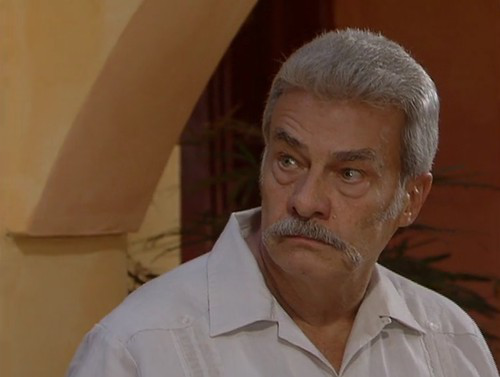

In [6]:
item = data[0]
img = Image.open(f"../{split}/{item['filename']}")
w,h = img.size

img

Now lets plot the bounding boxes for each aspect ratio.

In [7]:
def draw_bbox(img: Image, bbox: List[int], width=3, color="green"):
    draw = ImageDraw.Draw(img)
    
    draw.rectangle(xy=bbox, fill=None, width=width,outline=color)
    return img

img_with_bbox = img.copy()

# Let's assign the bounding box for each aspect ratio a different color.
colors = {'16:9': 'blue', '2:1': 'black', "3:4": "green", '4:3': 'yellow', '1:1': 'purple'}
for aspect_ratio, norm_bbox in item['crop_bboxes'].items():
    # We first need to denormalize the bounding box.
    bbox = denormalize_bbox(norm_bbox,w,h)
    draw_bbox(img_with_bbox,bbox,color=colors[aspect_ratio])

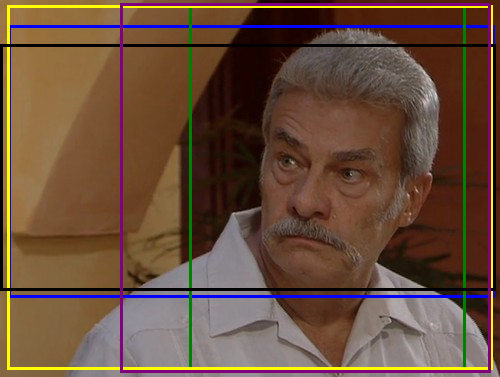

In [8]:
img_with_bbox

Often it's more helpful to look at the crops separately, so lets plot a few examples in a grid.

In [9]:
def pad_to_square(image: Image, resize=None):  # type:ignore
    """
    Use PIL to pad the smaller dimension of an image to make it square.
    Optionally also resizes the padded image to the desired size.
    """
    desired_size = max((image.height, image.width))
    delta_w = max(desired_size - image.width, 0)
    delta_h = max(desired_size - image.height, 0)

    padding = (delta_w // 2, delta_h // 2, delta_w - (delta_w // 2), delta_h - (delta_h // 2))
    image = ImageOps.expand(image, padding,fill=(255,255,255))
    if resize is not None:
        image = image.resize((resize,resize), Image.BICUBIC)
    return image

In [10]:
all_images = []
row_titles = []
plot_img_size = 200

for item in data[:3]:
    cell_titles = []
    
    img = Image.open(f"../train/{item['filename']}")
    row_images = [pad_to_square(img.copy(),resize=plot_img_size)]
    cell_titles.append("Original")
    
    w,h = img.size
    for aspect_ratio in ["2:1", "16:9","4:3","1:1","3:4"]:
        norm_bbox = item['crop_bboxes'][aspect_ratio]
        bbox = denormalize_bbox(norm_bbox,w,h)
        row_images.append(pad_to_square(img.copy().crop(bbox),resize=plot_img_size))
        cell_titles.append(aspect_ratio)
        
    row_titles.append(cell_titles)
    all_images.append(row_images)

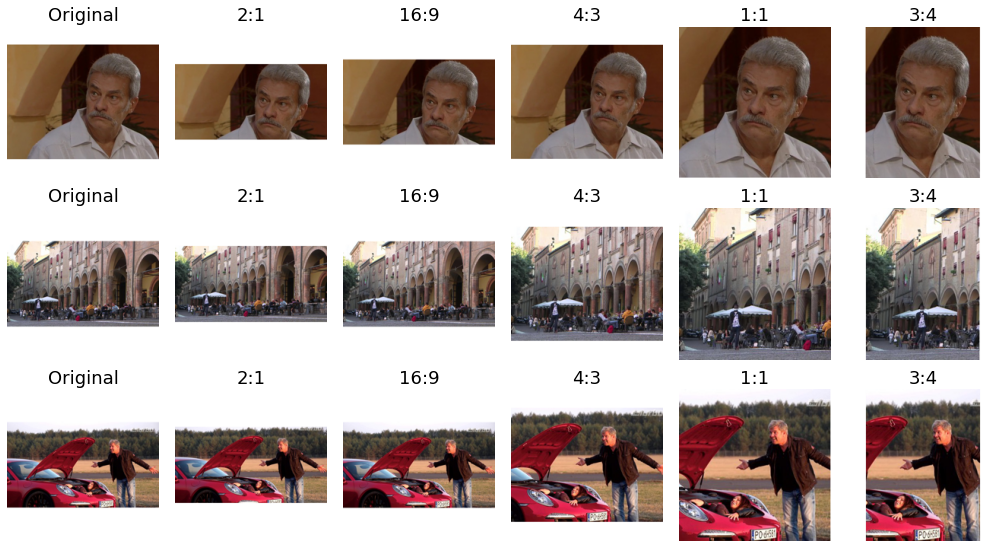

In [11]:
n_rows = len(all_images)
row_width = 14
row_height = 2.5
fig = plt.figure(constrained_layout=True, figsize=(row_width, row_height * n_rows))

subfigs = fig.subfigures(nrows=n_rows, ncols=1)
for row, subfig in enumerate(subfigs):
    axs = subfig.subplots(nrows=1, ncols=6)
    for col, ax in enumerate(axs):
        try:
            ax.imshow(all_images[row][col])
            ax.set_title(row_titles[row][col],fontsize=18)
        except Exception as e:
            pass
        ax.axis("off")
        
plt.savefig('../images/crop_example_multiple.jpeg', format='jpeg', dpi=300,pil_kwargs={'quality': 90})